# 04 图像滤波

## 算法理论介绍
### 均值滤波、方框滤波

**1. 滤波分类**

**线性滤波：** 对邻域中的像素的计算为线性运算时，如利用窗口函数进行平滑加权求和的运算，或者某种卷积运算，都可以称为线性滤波。常见的线性滤波有：均值滤波、高斯滤波、盒子滤波、拉普拉斯滤波等等，通常线性滤波器之间只是模版系数不同。

**非线性滤波：** 非线性滤波利用原始图像跟模版之间的一种逻辑关系得到结果，如最值滤波器，中值滤波器。比较常用的有中值滤波器和双边滤波器。


**2. 方框（盒子）滤波**

方框滤波是一种非常有用的线性滤波，也叫盒子滤波，均值滤波就是盒子滤波归一化的特殊情况。
**应用：** 可以说，一切需要求某个邻域内像素之和的场合，都有方框滤波的用武之地，比如：均值滤波、引导滤波、计算Haar特征等等。

**优势：** 就一个字：快！它可以使复杂度为O(MN)的求和，求方差等运算降低到O(1)或近似于O(1)的复杂度，也就是说与邻域尺寸无关了，有点类似积分图吧，但是比积分图更快（与它的实现方式有关）。

在原理上，是采用一个卷积核与图像进行卷积：
      
![](imgs/20200412125446419.png)

其中：
![](imgs/20200412125657652.png)             

可见，归一化了就是均值滤波；不归一化则可以计算每个像素邻域上的各种积分特性，方差、协方差，平方和等等。

**3. 均值滤波**

**均值滤波的应用场合：**
根据冈萨雷斯书中的描述，均值模糊可以模糊图像以便得到感兴趣物体的粗略描述，也就是说，去除图像中的不相关细节，其中“不相关”是指与滤波器模板尺寸相比较小的像素区域，从而对图像有一个整体的认知。即为了对感兴趣的物体得到一个大致的整体的描述而模糊一幅图像，忽略细小的细节。

**均值滤波的缺陷：**
均值滤波本身存在着固有的缺陷，即它不能很好地保护图像细节，在图像去噪的同时也破坏了图像的细节部分，从而使图像变得模糊，不能很好地去除噪声点。特别是椒盐噪声。

均值滤波是上述方框滤波的特殊情况，均值滤波方法是：对待处理的当前像素，选择一个模板，该模板为其邻近的若干个像素组成，用模板的均值（方框滤波归一化）来替代原像素的值。公式表示为：

![](imgs/2020041213054619.png)           

g(x,y)为该邻域的中心像素，n跟系数模版大小有关，一般3*3邻域的模板，n取为9，如：

[](imgs/20200412130646624.png)          

当然，模板是可变的，一般取奇数，如5 * 5 , 7 * 7等等。

注：在实际处理过程中可对图像边界进行扩充，扩充为0或扩充为邻近的像素值。

### 高斯滤波
**应用：** 高斯滤波是一种线性平滑滤波器，对于服从正态分布的噪声有很好的抑制作用。在实际场景中，我们通常会假定图像包含的噪声为高斯白噪声，所以在许多实际应用的预处理部分，都会采用高斯滤波抑制噪声，如传统车牌识别等。

高斯滤波和均值滤波一样，都是利用一个掩膜和图像进行卷积求解。不同之处在于：均值滤波器的模板系数都是相同的为1，而高斯滤波器的模板系数，则随着距离模板中心的增大而系数减小（服从二维高斯分布）。所以，高斯滤波器相比于均值滤波器对图像个模糊程度较小，更能够保持图像的整体细节。

二维高斯分布
高斯分布公式终于要出场了！

![](imgs/20200412165241878.png)  
其中不必纠结于系数，因为它只是一个常数！并不会影响互相之间的比例关系，并且最终都要进行归一化，所以在实际计算时我们是忽略它而只计算后半部分:
![](imgs/20200412165426976.png)  
其中(x,y)为掩膜内任一点的坐标，(ux,uy)为掩膜内中心点的坐标，在图像处理中可认为是整数；σ是标准差。

例如：要产生一个3×3的高斯滤波器模板，以模板的中心位置为坐标原点进行取样。模板在各个位置的坐标，如下所示（x轴水平向右，y轴竖直向下）。  

![](imgs/20200412165500464.png)  
这样，将各个位置的坐标带入到高斯函数中，得到的值就是模板的系数。
对于窗口模板的大小为 (2k+1)×(2k+1)，模板中各个元素值的计算公式如下：

![](imgs/20200412165519667.png)  
这样计算出来的模板有两种形式：小数和整数。

* 小数形式的模板，就是直接计算得到的值，没有经过任何的处理；
* 整数形式的，则需要进行归一化处理，将模板左上角的值归一化为1，具体介绍请看这篇博文。使用整数的模板时，需要在模板的前面加一个系数，系数为模板系数和的倒数。

**生成高斯掩膜（小数形式）**  
知道了高斯分布原理，实现起来也就不困难了。

首先我们要确定我们生产掩模的尺寸wsize，然后设定高斯分布的标准差。生成的过程，我们首先根据模板的大小，找到模板的中心位置center。 然后就是遍历，根据高斯分布的函数，计算模板中每个系数的值。

最后模板的每个系数要除以所有系数的和。这样就得到了小数形式的模板。 

```cpp
///////////////////////////////
//x，y方向联合实现获取高斯模板
//////////////////////////////
void generateGaussMask(cv::Mat& Mask,cv::Size wsize, double sigma){
	Mask.create(wsize,CV_64F);
	int h = wsize.height;
	int w = wsize.width;
	int center_h = (h - 1) / 2;
	int center_w = (w - 1) / 2;
	double sum = 0.0;
	double x, y;
	for (int i = 0; i < h; ++i){
		y = pow(i - center_h, 2);
		for (int j = 0; j < w; ++j){
			x = pow(j - center_w, 2);
			//因为最后都要归一化的，常数部分可以不计算，也减少了运算量
			double g = exp(-(x + y) / (2 * sigma*sigma));
			Mask.at<double>(i, j) = g;
			sum += g;
		}
	}
	Mask = Mask / sum;
}
```
**3×3,σ=0.8的小数型模板：**   

![](imgs/20200412165756162.png)  

**σ的意义及选取**   
通过上述的实现过程，不难发现，高斯滤波器模板的生成最重要的参数就是高斯分布的标准差σ。标准差代表着数据的离散程度，如果σ较小，那么生成的模板的中心系数较大，而周围的系数较小，这样对图像的平滑效果就不是很明显；反之，σ较大，则生成的模板的各个系数相差就不是很大，比较类似均值模板，对图像的平滑效果比较明显。

来看下一维高斯分布的概率分布密度图：

![](imgs/20200412165824372.png)

于是我们有如下结论：σ越小分布越瘦高，σ越大分布越矮胖。

* σ越大，分布越分散，各部分比重差别不大，于是生成的模板各元素值差别不大，类似于平均模板；
* σ越小，分布越集中，中间部分所占比重远远高于其他部分，反映到高斯模板上就是中心元素值远远大于其他元素值，于是自然而然就相当于中间值得点运算。

## 基于OpenCV的实现

### 2D卷积（图像过滤）
与一维信号一样，还可以使用各种低通滤波器（LPF），高通滤波器（HPF）等对图像进行滤波。LPF有助于消除噪声，使图像模糊等。HPF滤波器有助于在图像中找到边缘。

OpenCV提供了一个函数**cv.filter2D**来将内核与图像进行卷积。例如，我们将尝试对图像进行平均滤波。

操作如下:保持这个内核在一个像素上，将所有低于这个内核的25个像素相加，取其平均值，然后用新的平均值替换中心像素。它将对图像中的所有像素继续此操作。试试这个代码，并检查结果:



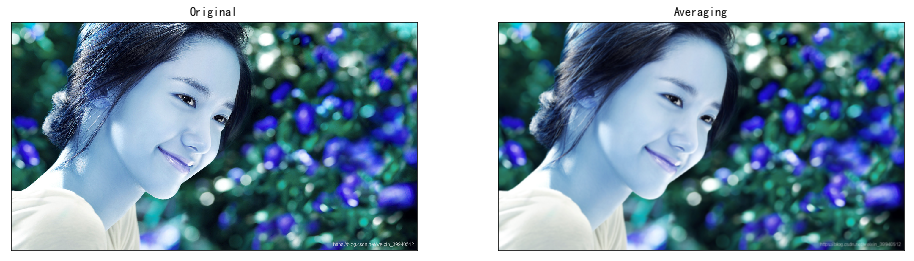

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('images/yun.jpg')
kernel = np.ones((5,5),np.float32)/25
dst = cv.filter2D(img,-1,kernel)
plt.figure(figsize=(16, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

### 图像模糊（图像平滑）
通过将图像与低通滤波器内核进行卷积来实现图像模糊。这对于消除噪音很有用。它实际上从图像中消除了高频部分（例如噪声，边缘）。因此，在此操作中边缘有些模糊。（有一些模糊技术也可以不模糊边缘）。OpenCV主要提供四种类型的模糊技术。

#### 1.平均
这是通过将图像与归一化框滤镜进行卷积来完成的。它仅获取内核区域下所有像素的平均值，并替换中心元素。这是通过功能**cv.blur()或**cv.boxFilter()完成的。检查文档以获取有关内核的更多详细信息。我们应该指定内核的宽度和高度。

注意 如果您不想使用标准化的框式过滤器，请使用**cv.boxFilter()**。将参数normalize = False传递给函数。

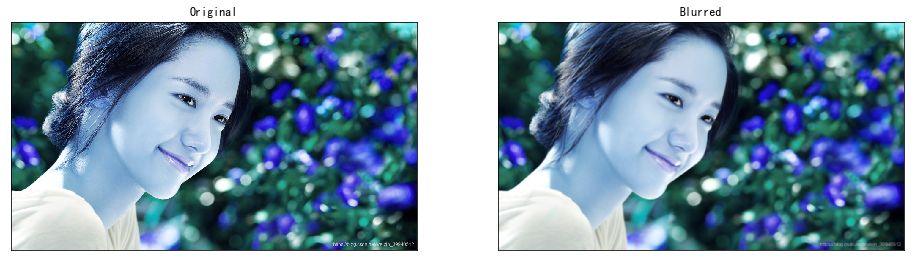

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('images/yun.jpg')
blur = cv.blur(img,(5,5))
plt.figure(figsize=(16, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

#### 2.高斯模糊
在这种情况下，代替盒式滤波器，使用了高斯核。这是通过功能**cv.GaussianBlur()** 完成的。我们应指定内核的宽度和高度，该宽度和高度应为正数和奇数。我们还应指定X和Y方向的标准偏差，分别为sigmaX和sigmaY。如果仅指定sigmaX，则将sigmaY与sigmaX相同。如果两个都为零，则根据内核大小进行计算。高斯模糊对于从图像中去除高斯噪声非常有效。

如果需要，可以使用函数**cv.getGaussianKernel()** 创建高斯内核。

可以修改以上代码以实现高斯模糊：

blur = cv.GaussianBlur(img,(5,5),0)

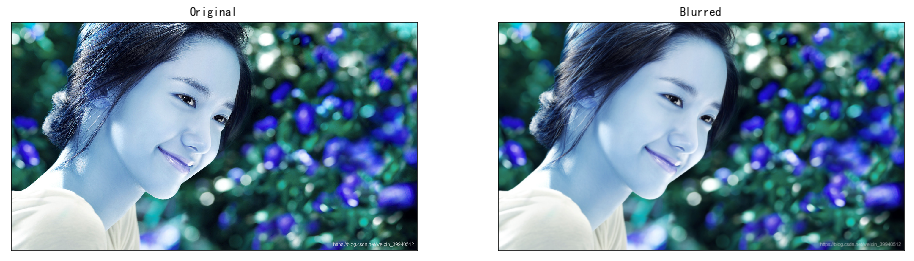

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('images/yun.jpg')
blur = cv.GaussianBlur(img,(5,5),0)
plt.figure(figsize=(16, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

#### 3.中位模糊
在这里，函数**cv.medianBlur()** 提取内核区域下所有像素的中值，并将中心元素替换为该中值。这对于消除图像中的椒盐噪声非常有效。有趣的是，在上述过滤器中，中心元素是新计算的值，该值可以是图像中的像素值或新值。但是在中值模糊中，中心元素总是被图像中的某些像素值代替。有效降低噪音。其内核大小应为正奇数整数。

在此演示中，我向原始图像添加了50％的噪声并应用了中值模糊。检查结果：

median = cv.medianBlur(img,5)

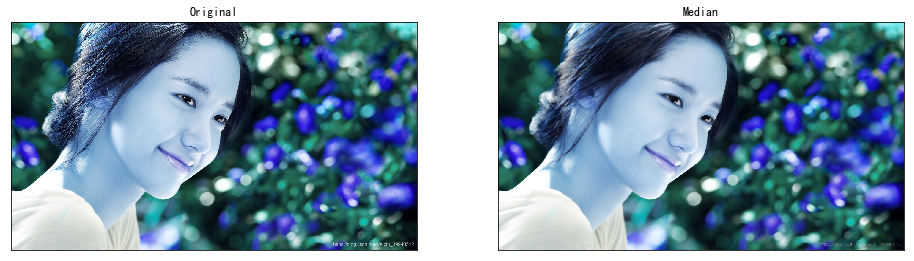

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('images/yun.jpg')
median = cv.medianBlur(img,5)
plt.figure(figsize=(16, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(median),plt.title('Median')
plt.xticks([]), plt.yticks([])
plt.show()

#### 4.双边滤波
cv.bilateralFilter() 在去除噪声的同时保持边缘清晰锐利非常有效。但是，与其他过滤器相比，该操作速度较慢。我们已经看到，高斯滤波器采用像素周围的邻域并找到其高斯加权平均值。高斯滤波器仅是空间的函数，也就是说，滤波时会考虑附近的像素。它不考虑像素是否具有几乎相同的强度。它不考虑像素是否是边缘像素。因此它也模糊了边缘，这是我们不想做的。

双边滤波器在空间中也采用高斯滤波器，但是又有一个高斯滤波器，它是像素差的函数。空间的高斯函数确保仅考虑附近像素的模糊，而强度差的高斯函数确保仅考虑强度与中心像素相似的那些像素的模糊。由于边缘的像素强度变化较大，因此可以保留边缘。

以下示例显示了使用双边过滤器（有关参数的详细信息，请访问docs）。

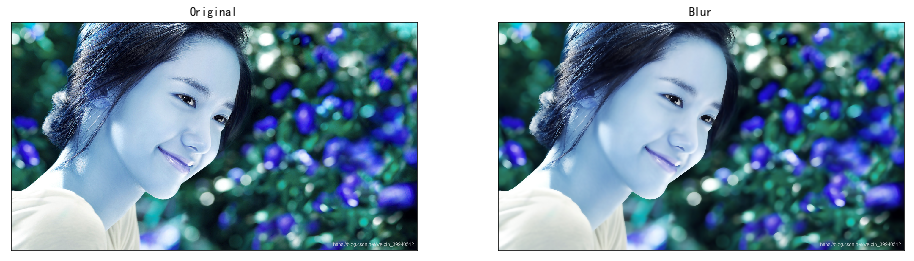

In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('images/yun.jpg')
blur = cv.bilateralFilter(img,9,75,75)
plt.figure(figsize=(16, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])
plt.show()